<a href="https://colab.research.google.com/github/jbigham878/nflseasonmodeling/blob/main/NFL_Playoff_Results_by_Season_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports & Definitions**

In [ ]:
# All imports in one place for convenience
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import requests

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



### **Data Cleaning & Exploration**

In [ ]:
offense_url = "https://github.com/jbigham878/nflseasonmodeling/raw/main/Offense.xlsx"

offense_file = requests.get(offense_url).content

offense = pd.read_excel(offense_file)

defense_url = "https://github.com/jbigham878/nflseasonmodeling/raw/main/Defense.xlsx"

defense_file = requests.get(defense_url).content

defense = pd.read_excel(defense_file)

defense

# Clean files of any name changes

# dictionary of new team names
new_team_names = {'Oakland Raiders': 'Las Vegas Raiders','San Diego Chargers': 'Los Angeles Chargers', 'St. Louis Rams': 'Los Angeles Rams', 'Washington Redskins' : 'Washington Commanders','Washington Football Team':'Washington Commanders'}

offense_cleaned = offense.replace({'Tm': new_team_names})

defense_cleaned = defense.replace({'Tm': new_team_names})

In [ ]:
defense_cleaned

,Year,Tm,G,PA,Yds_Allowed,Y/P_Allowed,TO_Forced,Pass1stD_Allowed,PassYds_Allowed,Pass_TD_Allowed,Int,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed
0,2003,New England Patriots,16,238,4666,4.4,41,293,3232,11,29,4.9,1434,10,3.6,107,25,23.0,19.5,280.69
1,2003,Dallas Cowboys,16,260,4056,4.3,25,228,2631,18,13,5.0,1425,7,3.5,88,33,23.4,11.2,187.28
2,2003,Miami Dolphins,16,261,4787,4.7,36,283,3335,12,22,5.8,1452,11,3.3,98,30,25.3,17.0,205.62
3,2003,Tampa Bay Buccaneers,16,264,4466,4.6,33,249,2710,16,20,5.3,1756,6,3.9,104,20,25.4,16.4,226.87
4,2003,Buffalo Bills,16,279,4313,4.3,18,270,2707,18,10,5.0,1606,11,3.5,110,25,26.9,9.3,207.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2018,San Francisco 49ers,16,435,5546,5.4,7,337,3732,35,2,6.4,1814,13,4.1,117,38,39.8,3.9,-126.92
627,2018,New York Jets,16,441,6086,5.7,20,343,4065,29,13,6.5,2021,16,4.6,95,38,39.1,9.9,-73.31
628,2018,Cincinnati Bengals,16,455,6618,6.1,18,372,4414,32,12,7.1,2204,17,4.7,113,26,46.3,10.2,-164.84
629,2018,Tampa Bay Buccaneers,16,464,6134,6.1,17,356,4151,34,9,7.3,1983,19,4.7,127,25,40.7,8.2,-152.18


In [ ]:
# Append Offensive data and Defensive Data to create a list of all possible features

stats = pd.merge(offense_cleaned, defense_cleaned, on=["Year", "Tm"])


stats

,Year,Tm,G_x,PF,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,Int,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed
0,2004,Indianapolis Colts,16,522,6475,968,6.7,17,379,4623,...,19,6.5,2037,12,4.6,116,19,35.4,18.5,50.75
1,2004,Kansas City Chiefs,16,483,6695,1089,6.1,27,398,4406,...,13,7.5,1834,18,4.6,117,40,38.8,10.9,6.49
2,2004,Los Angeles Chargers,16,446,5542,996,5.6,18,328,3357,...,23,6.4,1307,15,3.7,109,41,29.5,17.5,66.50
3,2004,New England Patriots,16,437,5722,1035,5.5,27,344,3588,...,20,5.8,1572,9,3.9,118,30,24.0,20.0,244.33
4,2004,Green Bay Packers,16,424,6357,1053,6.0,29,354,4449,...,8,6.6,1878,12,4.6,112,34,34.3,7.7,20.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2022,Tennessee Titans,17,298,5045,992,5.1,23,277,2914,...,14,6.6,1307,9,3.4,115,31,33.9,10.6,-52.12
627,2022,New York Jets,17,296,5409,1074,5.0,23,294,3723,...,12,5.4,2068,14,4.2,90,27,32.3,8.3,25.96
628,2022,Houston Texans,17,289,4820,1015,4.7,28,277,3344,...,16,6.3,2894,25,5.1,95,26,35.2,11.9,-80.38
629,2022,Indianapolis Colts,17,289,5298,1103,4.8,34,310,3432,...,10,6.1,2109,20,4.1,89,33,36.0,10.2,-51.07


In [ ]:
playoffs_url = "https://github.com/jbigham878/nflseasonmodeling/raw/main/Playoff Results.xlsx"

playoffs_file = requests.get(playoffs_url).content

playoffs = pd.read_excel(playoffs_file)

playoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        237 non-null    int64 
 1   Week        237 non-null    object
 2   Winner/tie  237 non-null    object
 3   Loser/tie   237 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.5+ KB


In [ ]:
#Define a function that looks at the playoff results and places each team's results in a bucket 1: Wildcard, 2:Divisional, 3: ConfChamp, 4: Superbowl Runner ups, 5: Superbowl Winners
def playoff_results_by_year(year):
  year_results = playoffs[playoffs['Year'] == year]
  winner = ''
  for idx, row in year_results.iterrows():
    if year_results.loc[idx,'Week'] == 'WildCard':
       year_results.loc[idx,'Week'] = 1
    if year_results.loc[idx,'Week'] == 'Division':
       year_results.loc[idx,'Week'] = 2
    if year_results.loc[idx,'Week'] == 'ConfChamp':
       year_results.loc[idx,'Week'] = 3
    if year_results.loc[idx,'Week'] == 'SuperBowl':
       year_results.loc[idx,'Week'] = 4
       winner = year_results.loc[idx,'Winner/tie']

  #Append Winner's row
  year_results = pd.concat([year_results, pd.DataFrame.from_records([{'Year': str(year), 'Week': 5, 'Winner/tie': 'to be dropped', 'Loser/tie': winner}])])

  # Drop columns we dont need and rename loser column to the team column
  year_results.drop('Winner/tie',axis=1,inplace=True)
  year_results.rename(columns={"Week": "Points","Loser/tie": "Tm"},inplace=True)

  return year_results

playoff_results_by_year(2022)

,Year,Points,Tm
48,2022,1,Los Angeles Chargers
49,2022,1,Seattle Seahawks
50,2022,1,Miami Dolphins
51,2022,1,Baltimore Ravens
52,2022,1,Minnesota Vikings
53,2022,1,Tampa Bay Buccaneers
54,2022,2,Jacksonville Jaguars
55,2022,2,New York Giants
56,2022,2,Buffalo Bills
57,2022,2,Dallas Cowboys


In [ ]:
# Create master df of all playoff results

playoff_results = playoff_results_by_year(2003)

for x in range(2004, 2023):
  x_results = playoff_results_by_year(x)
  playoff_results = pd.concat([playoff_results, x_results])

playoff_results_cleaned = playoff_results.replace({'Tm': new_team_names})

# Convert Year column to integer
playoff_results_cleaned['Year'] = playoff_results_cleaned['Year'].astype('int64')

In [ ]:
# Create df with all playoff results

stats_with_results = pd.merge(stats, playoff_results_cleaned, on=["Year", "Tm"],how="outer")

# Replace all NaN in the points column with 0. These are teams that didn't make the playoffs

stats_with_results_cleaned = stats_with_results.fillna(0)

cols_to_numeric = stats_with_results_cleaned.columns.drop('Tm')

stats_with_results_cleaned[cols_to_numeric] = stats_with_results_cleaned[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

stats_with_results_cleaned.head(5)

,Year,Tm,G_x,PF,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed,Points
0,2004,Indianapolis Colts,16,522,6475,968,6.7,17,379,4623,...,6.5,2037,12,4.6,116,19,35.4,18.5,50.75,2
1,2004,Kansas City Chiefs,16,483,6695,1089,6.1,27,398,4406,...,7.5,1834,18,4.6,117,40,38.8,10.9,6.49,0
2,2004,Los Angeles Chargers,16,446,5542,996,5.6,18,328,3357,...,6.4,1307,15,3.7,109,41,29.5,17.5,66.50,1
3,2004,New England Patriots,16,437,5722,1035,5.5,27,344,3588,...,5.8,1572,9,3.9,118,30,24.0,20.0,244.33,5
4,2004,Green Bay Packers,16,424,6357,1053,6.0,29,354,4449,...,6.6,1878,12,4.6,112,34,34.3,7.7,20.76,1


### **Feature Engineering**

In [ ]:
# Show most correlated columns

stats_corr = stats_with_results_cleaned.corr()

stats_corr['Points'].sort_values(ascending=False)

<ipython-input-10-c5dff239516e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats_corr = stats_with_results_cleaned.corr()


Points              1.000000
PF                  0.558518
Sc_Pct_Offense      0.515011
Pass_NY/A           0.465225
PassTD              0.416457
Y/P                 0.395435
Total_Yds           0.390564
EXP                 0.383669
Pass_1stD           0.375878
RushTD              0.356341
TO_Pct_Defense      0.326274
TO_Forced           0.294486
Int                 0.270647
PassYds             0.266433
Rush1stD            0.243397
RushYds             0.226278
EXP_Pts_Allowed     0.220588
Ply                 0.154571
1stPy               0.120256
RushY/A             0.077757
Defensive_Pen       0.035429
G_x                -0.002598
G_y                -0.002598
Year               -0.004815
1stPy_Allowed      -0.046468
RushY/A_Allowed    -0.093369
Pen_Offense        -0.107386
PassYds_Allowed    -0.107388
Pass1stD_Allowed   -0.195302
Pass_TD_Allowed    -0.228572
Yds_Allowed        -0.267001
Y/P_Allowed        -0.271200
RushTD_Allowed     -0.283312
RushYds_Allowed    -0.313072
Int_Thrown    

In [ ]:
#set a mininum coorelation to be considered a factor

corr_floor = 0.4

# Find all values with a higher correlation with Points than the Floor
points_corr_values = stats_corr[stats_corr['Points'].abs() > corr_floor]

factors = list(points_corr_values.index)

factors

['PF', 'PassTD', 'Pass_NY/A', 'Sc_Pct_Offense', 'PA', 'Points']

In [ ]:
X = stats_with_results_cleaned[factors]
Y = stats_with_results_cleaned.Points

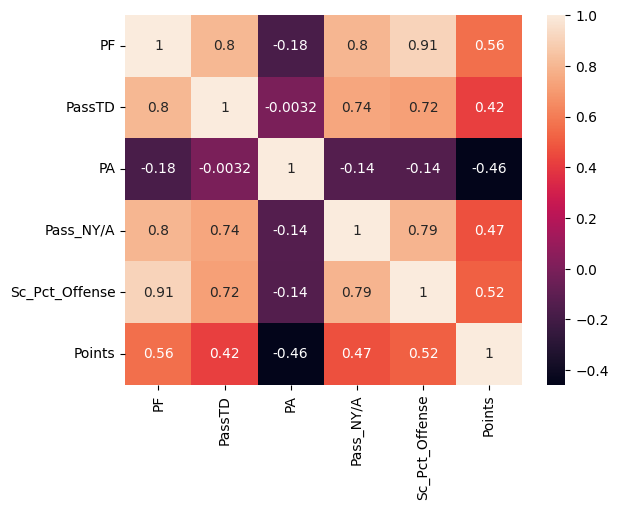

In [ ]:
sns.heatmap(stats_with_results_cleaned[['PF','PassTD','PA','Pass_NY/A','Sc_Pct_Offense','Points']].corr(),annot=True);

### **Linear Classification**

In [ ]:
# split out the dataset

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [ ]:
# create the Logistic Classification model

lr = LogisticRegression(solver='lbfgs',multi_class='multinomial', random_state=4)
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=4)

In [ ]:
# get predictions into a array

predictions_lr = lr.predict(X_test)

predictions_lr

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 1,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 4, 0, 0, 0, 1, 2, 0, 0, 0,
       2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0])

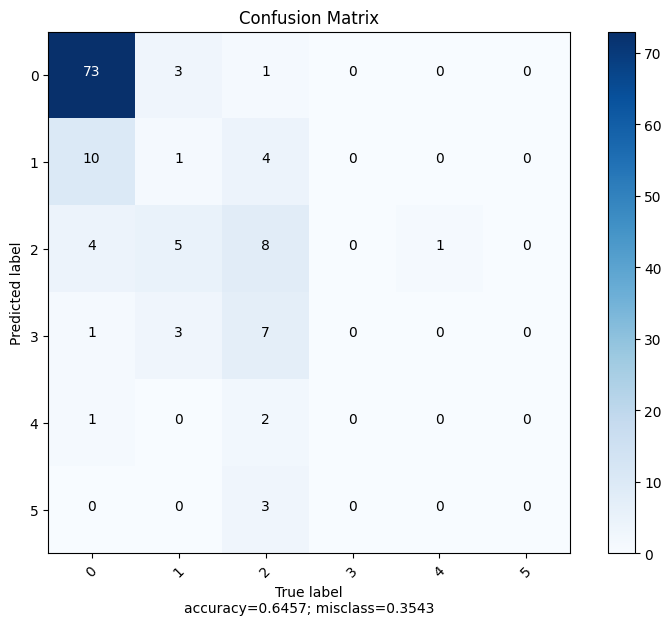

In [ ]:
# plot confusion matrix of predictions

confusion = confusion_matrix(y_test, predictions_lr)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)


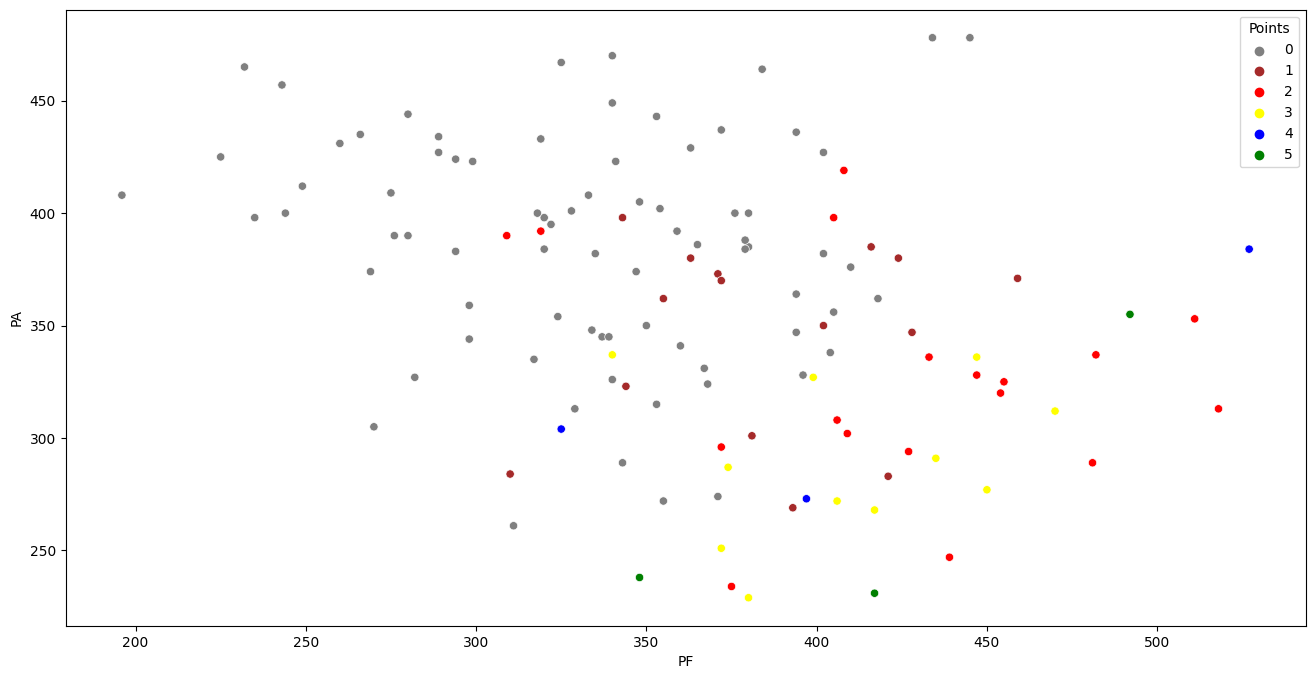

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,1)
sns.scatterplot(x = 'PF', y='PA', data=X_test,  hue=y_test,palette=['gray','brown','red','yellow','blue','green'])
#ax.set_ylim(3000, 8000)
#ax.set_xlim(15, 50)
plt.show()

In [ ]:
# Accuracy scores

acc_train = lr.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = lr.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.6944 
Accuracy on test = 0.6457 


### **Decision Tree**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

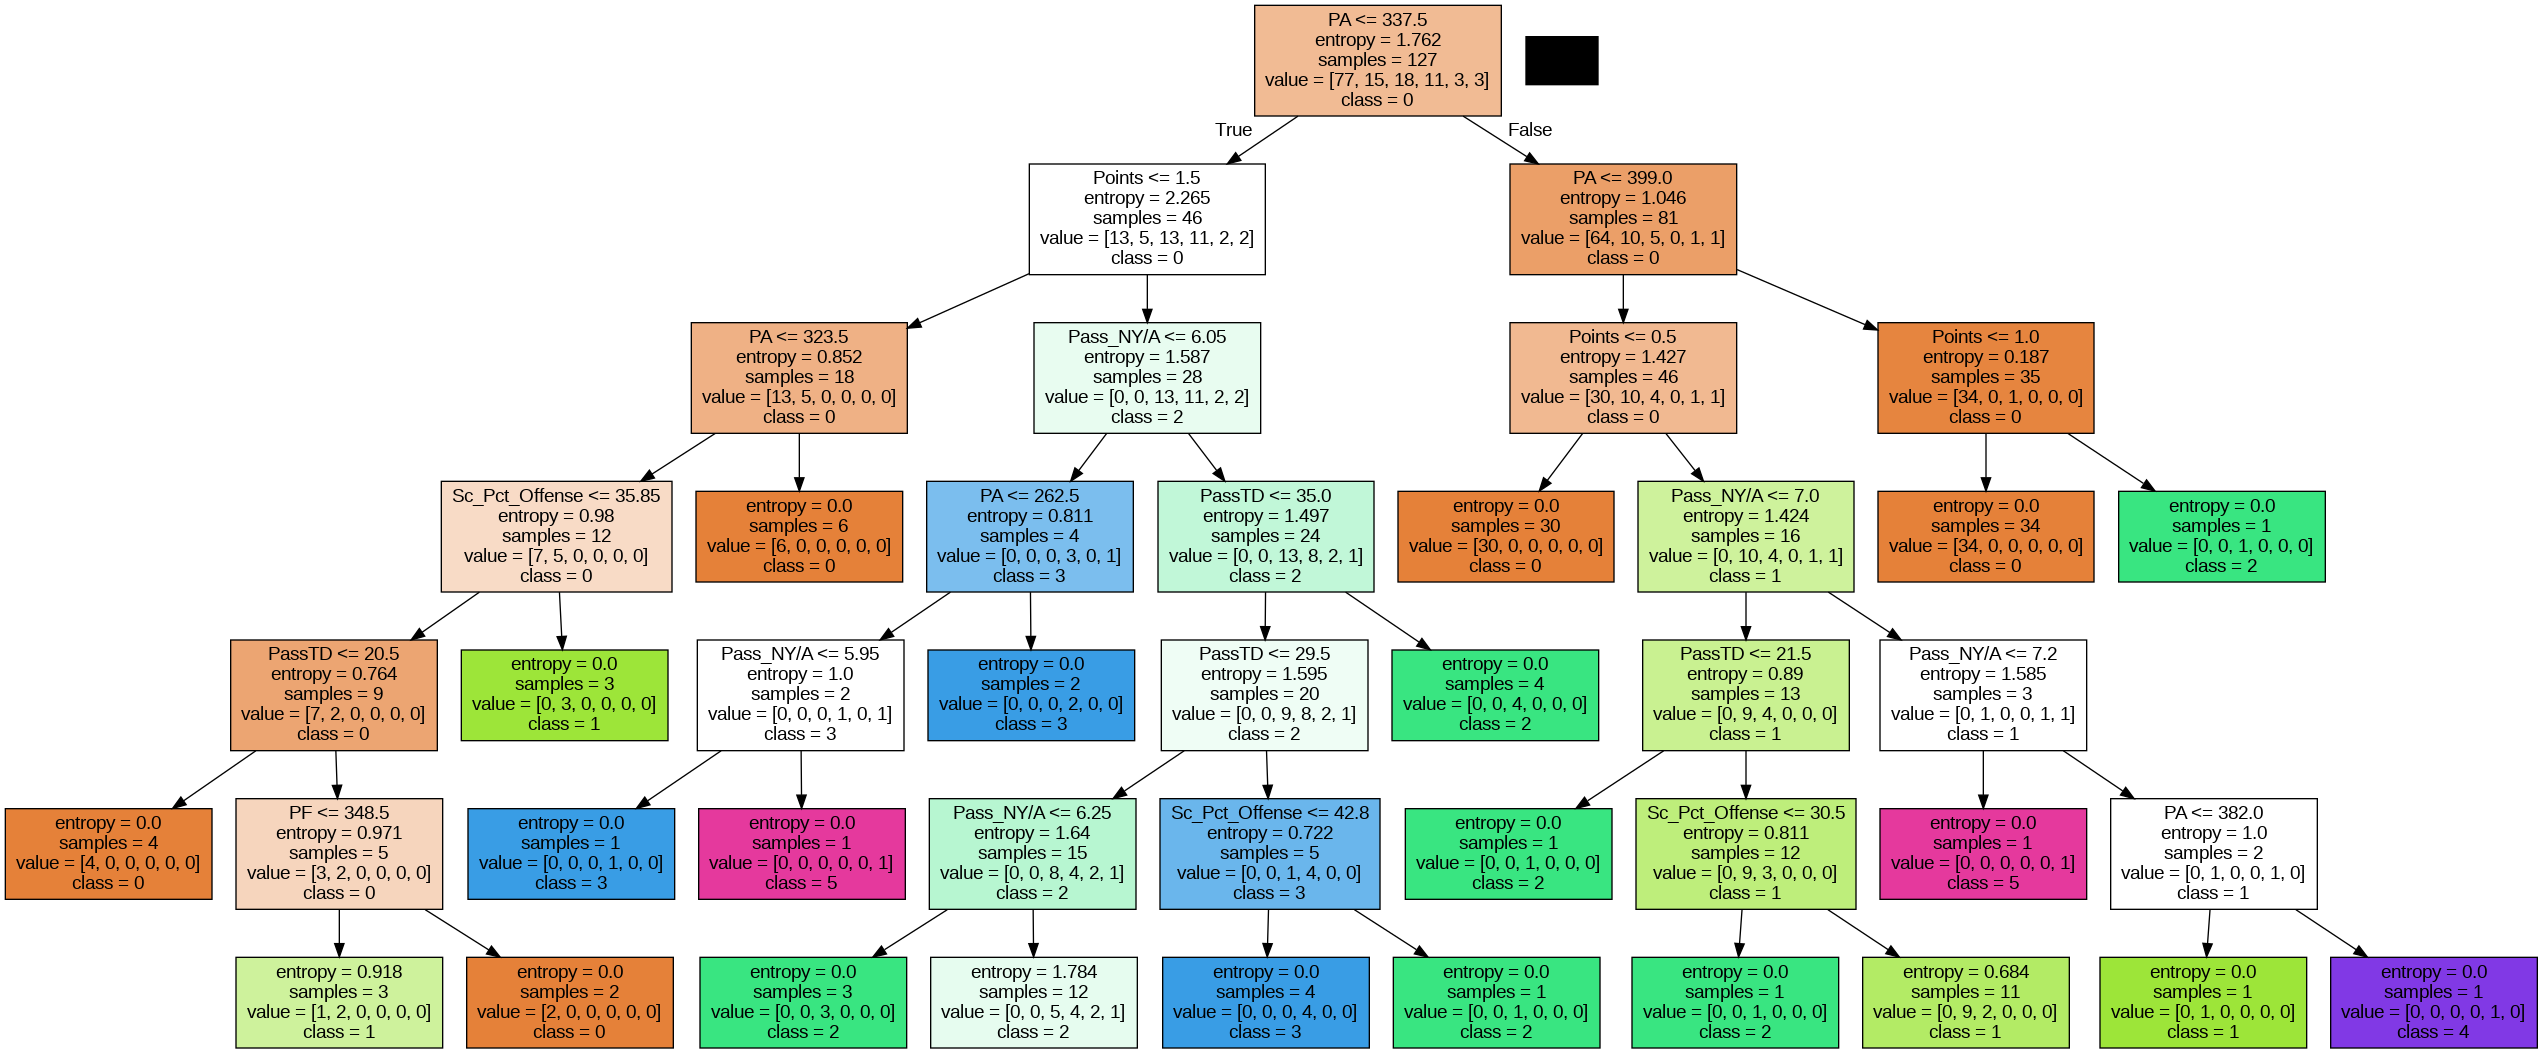

In [ ]:
# This is the model
from sklearn import tree

# A convenience for displaying visualizations
from IPython.display import Image

# Packages for rendering the tree
import pydotplus
import graphviz

# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=6,
    random_state = 1337
)
Tree = decision_tree.fit(X_test, y_test)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_test.columns,
    class_names=['0', '1','2', '3','4', '5'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
# Show accuracy scores

acc_train = Tree.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = Tree.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.7321 
Accuracy on test = 0.9213 


In [ ]:
Y_tree = Tree.predict(X_test)

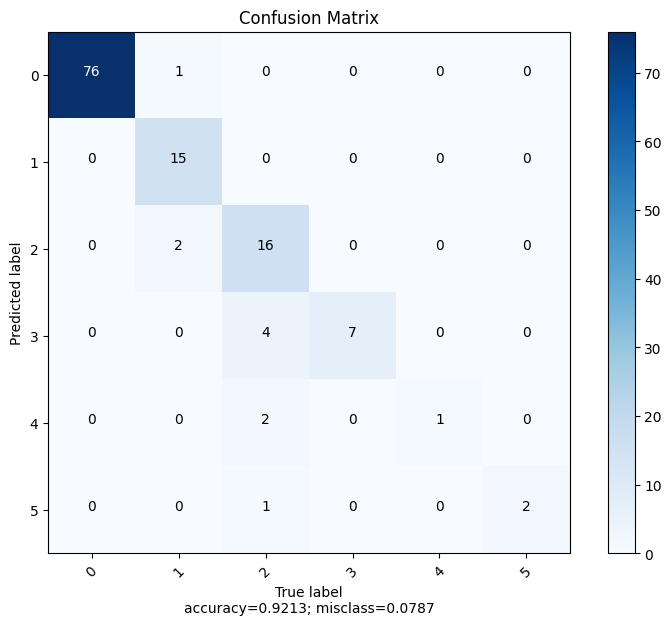

In [ ]:
confusion = confusion_matrix(y_test, Y_tree)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

### **Tuning Model Performance**

Decision Tree - depths = 8

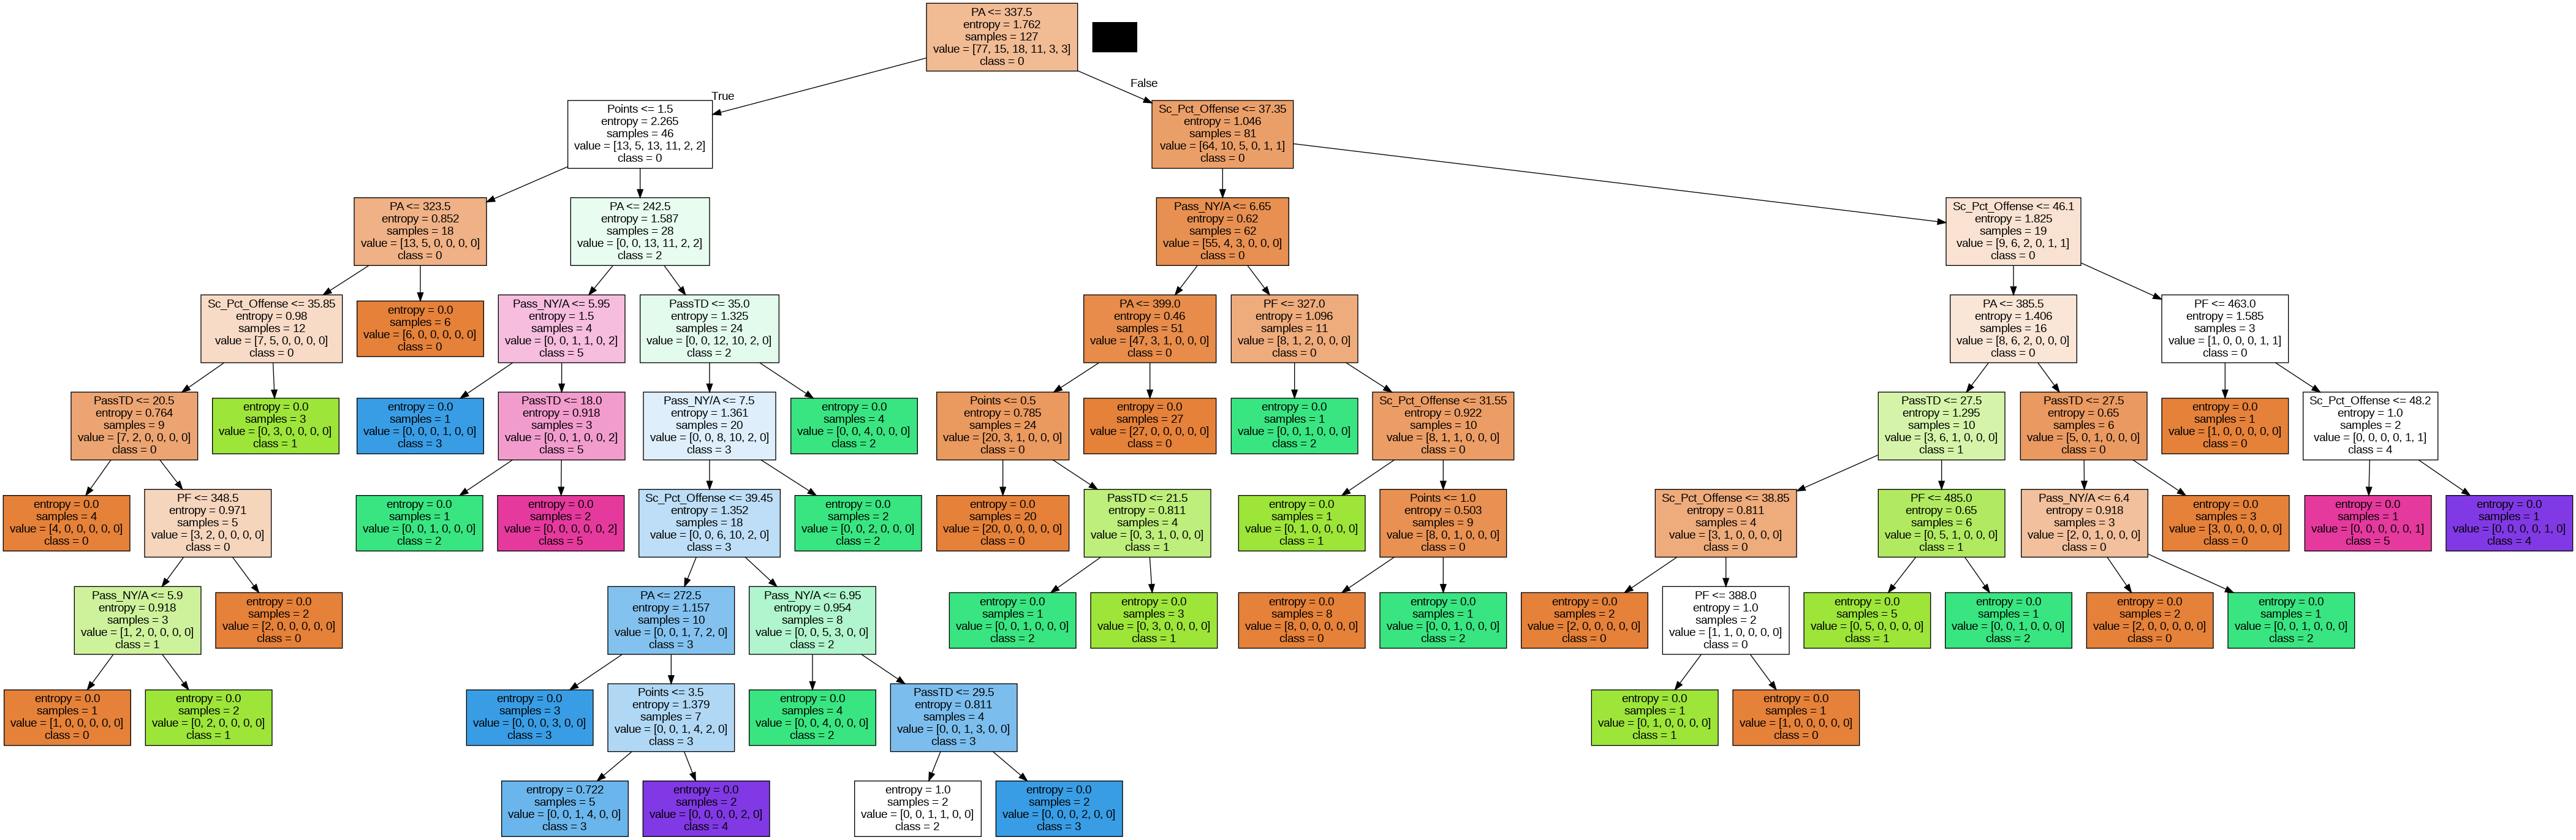

In [ ]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=8,
    random_state = 1337
)
Tree8 = decision_tree.fit(X_test, y_test)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_test.columns,
    class_names=['0', '1','2', '3','4', '5'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
# Show accuracy scores
Y_tree8 = Tree8.predict(X_test)

acc_train = Tree8.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = Tree8.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.6746 
Accuracy on test = 0.9843 


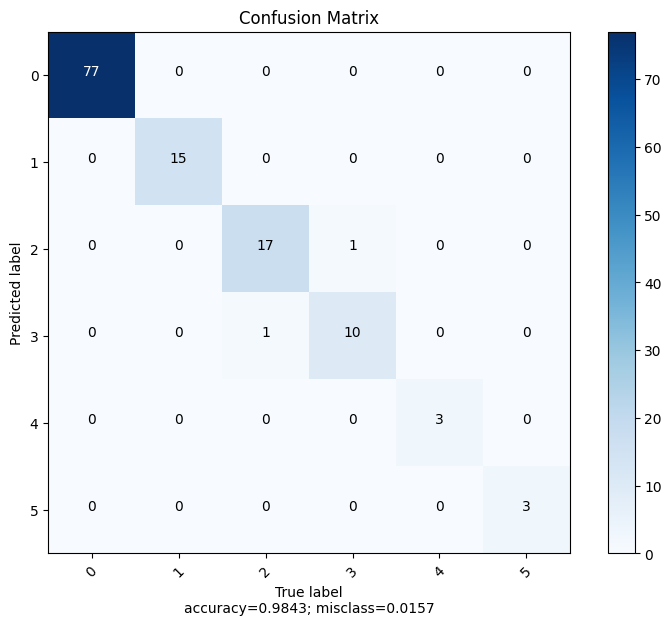

In [ ]:
confusion = confusion_matrix(y_test, Y_tree8)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

Decision Tree - depths = 4

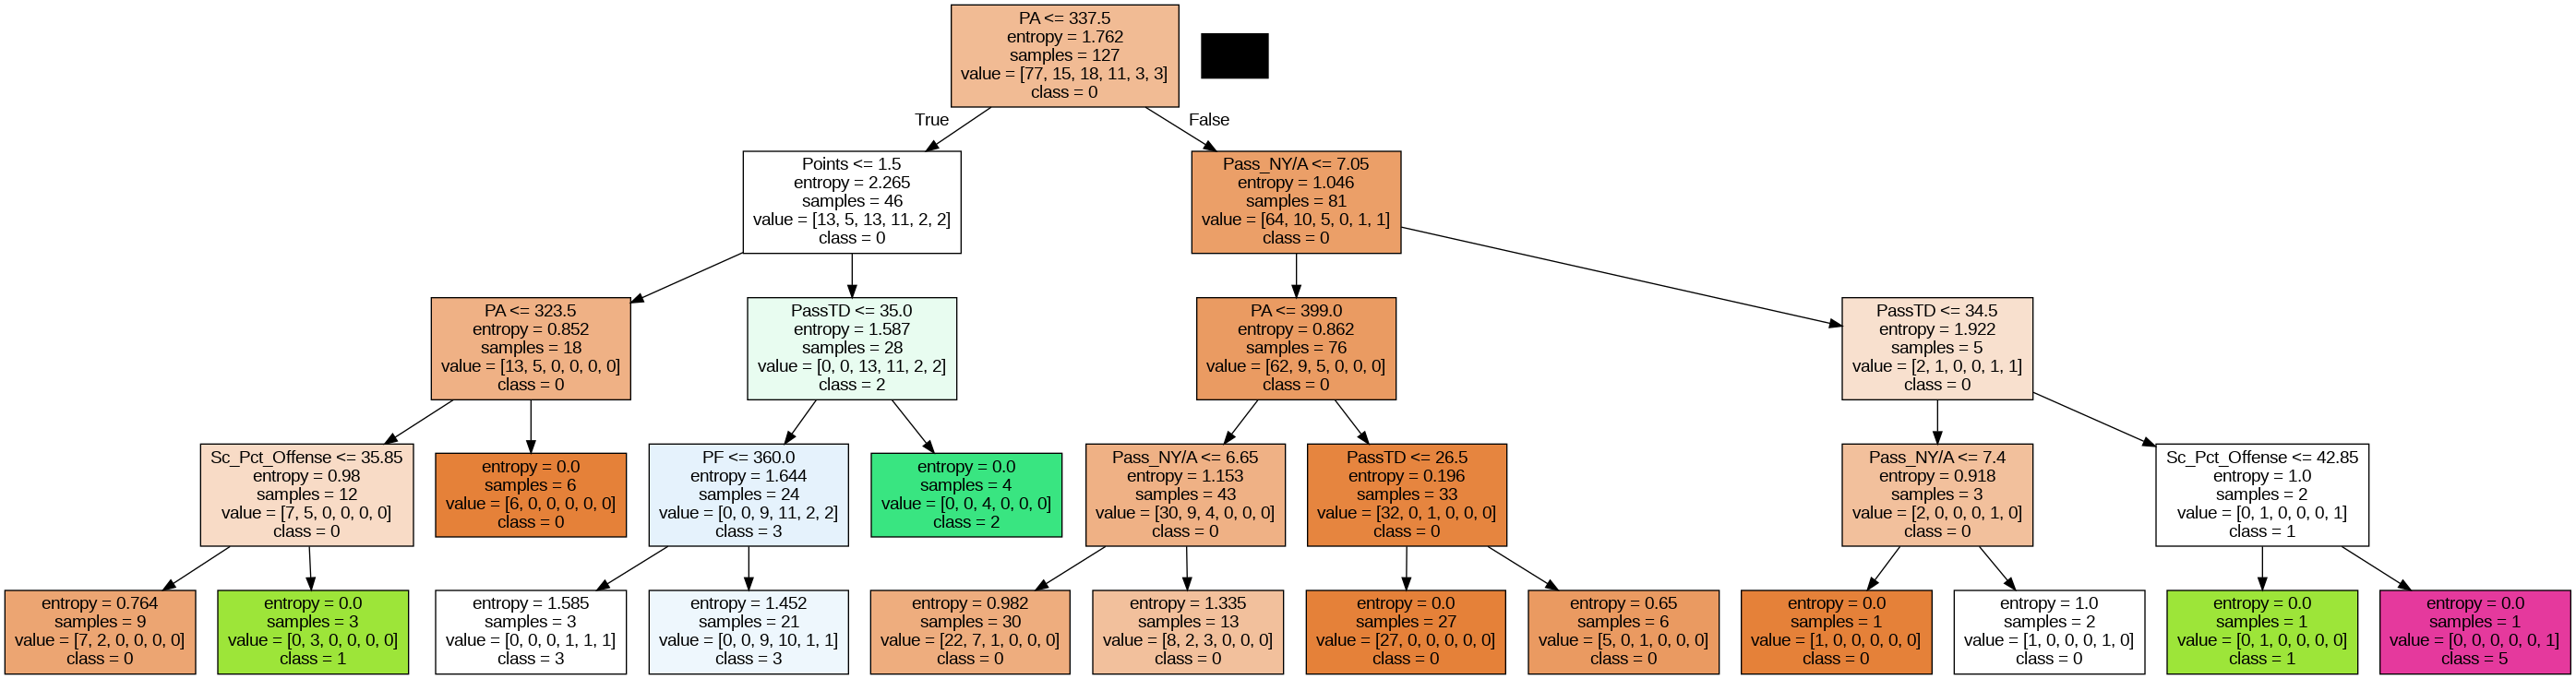

In [ ]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
Tree4 = decision_tree.fit(X_test, y_test)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_test.columns,
    class_names=['0', '1','2', '3','4', '5'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
# Show accuracy scores
Y_tree4 = Tree4.predict(X_test)

acc_train = Tree4.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = Tree4.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.6647 
Accuracy on test = 0.7638 


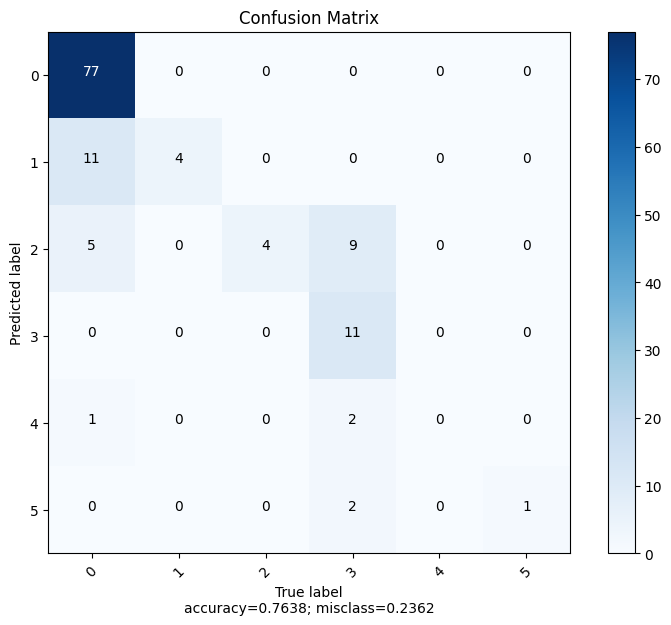

In [ ]:
confusion = confusion_matrix(y_test, Y_tree4)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

## **Playoff Predictions Function - Testing for past years and future**

In [ ]:
def playoff_predictions(Year):

  # filter DF down to the year
  filtered_stats = stats_with_results_cleaned[stats_with_results_cleaned['Year'] == Year]

  #split data into x factors and y target
  X_year = filtered_stats[factors]
  Y_year = filtered_stats.Points

  # Run the best decision tree to get predictions
  Y_Tree8_preds = Tree8.predict(X_year)

  filtered_stats['PREDICTED RESULTS'] = Y_Tree8_preds

  results_df = filtered_stats[['Tm','Points','PREDICTED RESULTS']]

  confusion = confusion_matrix(Y_year, Y_Tree8_preds)

  confusion_plot = plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

  acc_test = Tree8.score(X_year, Y_year)

  print("Accuracy for {:0.4f} = {:0.4f} ".format(int(Year),acc_test))

  return results_df.sort_values(by='Points'),confusion_plot

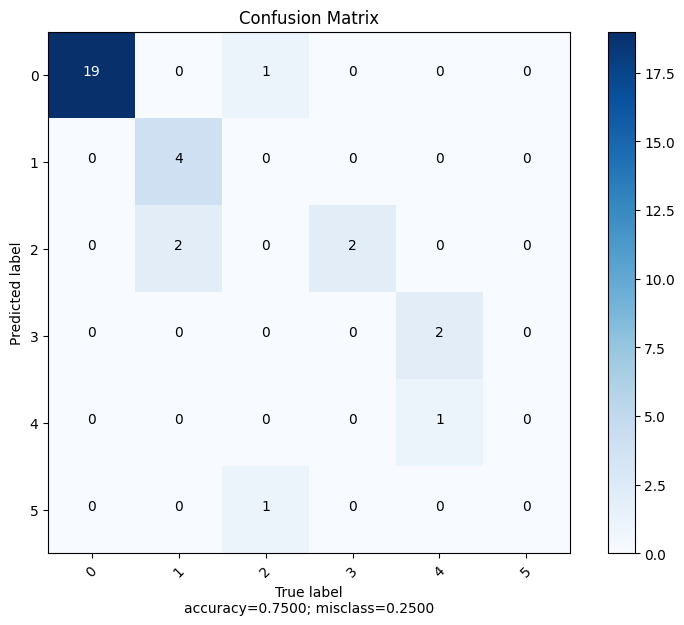

Accuracy for 2018.0000 = 0.7500 


(                        Tm  Points  PREDICTED RESULTS
 486        New York Giants       0                  2
 500          Buffalo Bills       0                  0
 499  Washington Commanders       0                  0
 498      Las Vegas Raiders       0                  0
 497       Tennessee Titans       0                  0
 496         Miami Dolphins       0                  0
 495          Detroit Lions       0                  0
 494         Denver Broncos       0                  0
 493          New York Jets       0                  0
 491    San Francisco 49ers       0                  0
 490       Cleveland Browns       0                  0
 489      Minnesota Vikings       0                  0
 487     Cincinnati Bengals       0                  0
 501   Jacksonville Jaguars       0                  0
 502      Arizona Cardinals       0                  0
 484      Green Bay Packers       0                  0
 485      Carolina Panthers       0                  0
 480      

In [ ]:
playoff_predictions(2018)

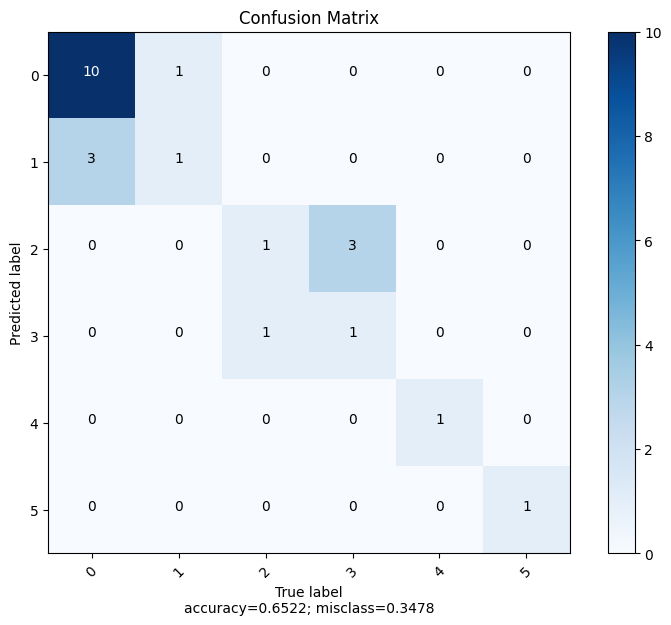

Accuracy for 2003.0000 = 0.6522 


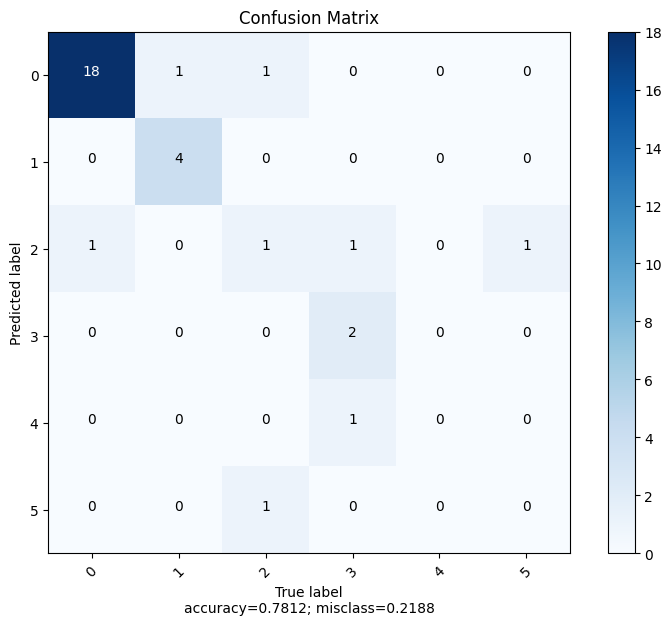

Accuracy for 2004.0000 = 0.7812 


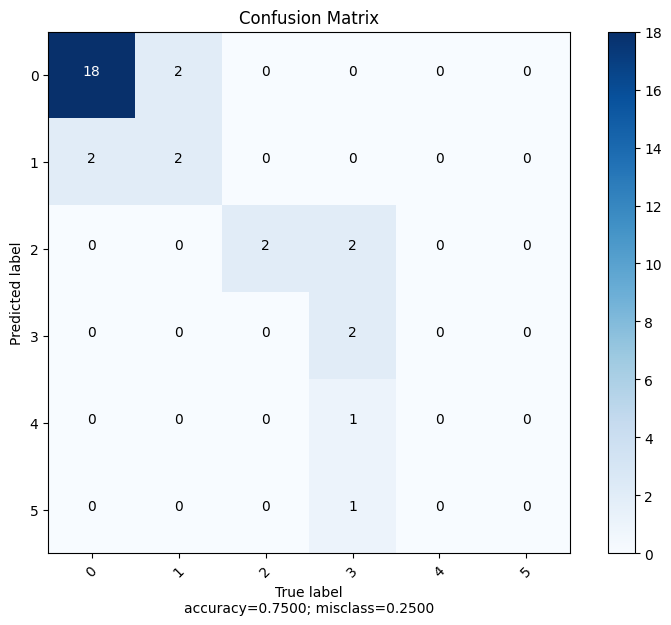

Accuracy for 2005.0000 = 0.7500 


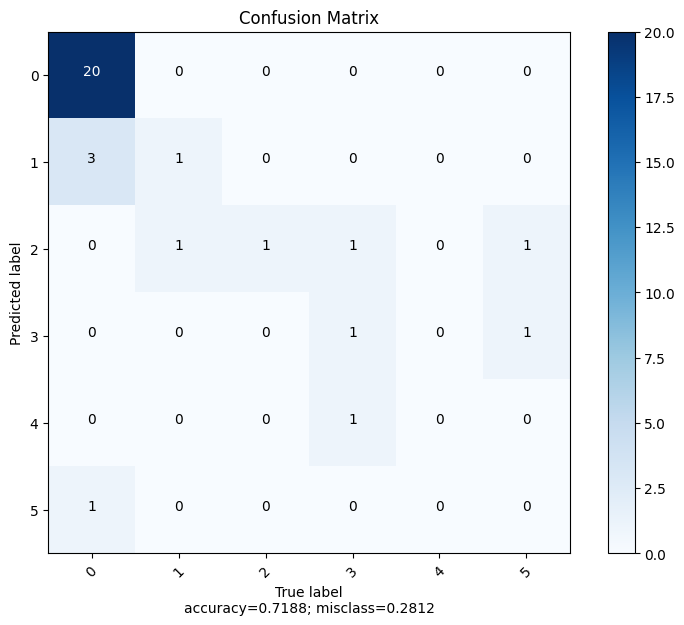

Accuracy for 2006.0000 = 0.7188 


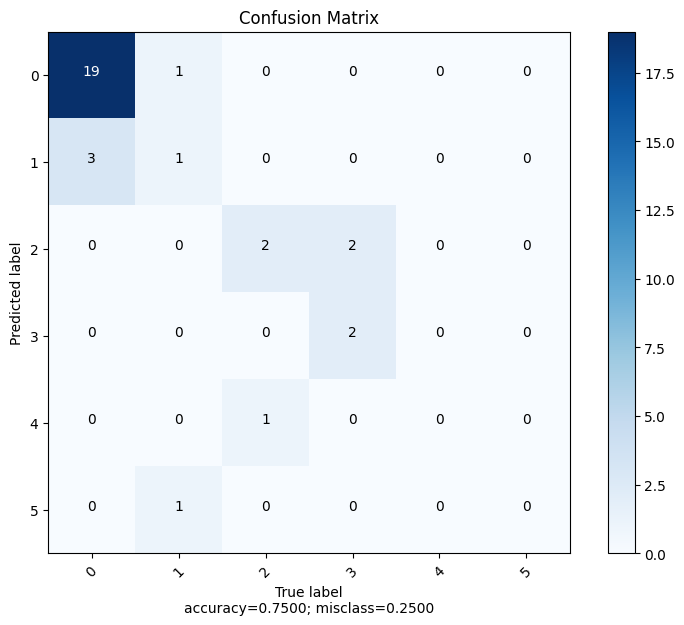

Accuracy for 2007.0000 = 0.7500 


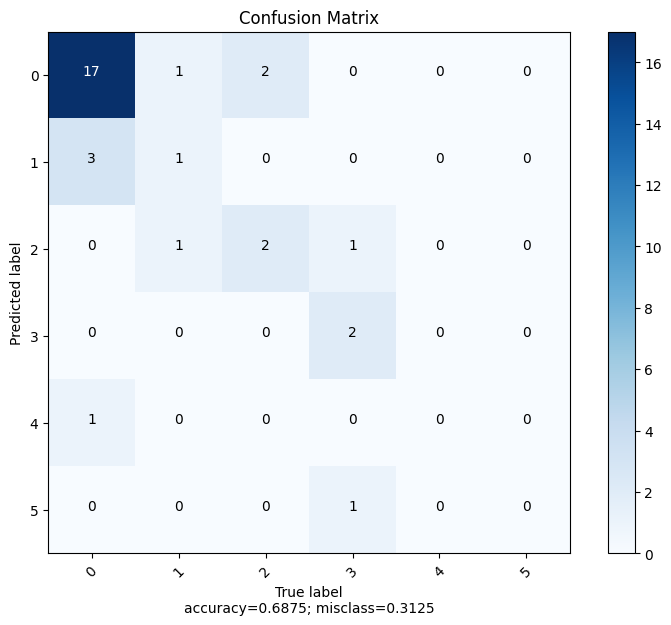

Accuracy for 2008.0000 = 0.6875 


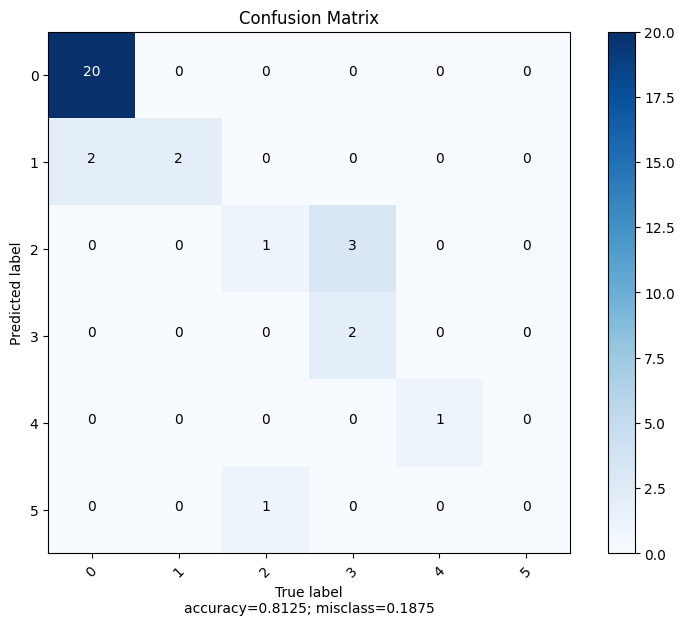

Accuracy for 2009.0000 = 0.8125 


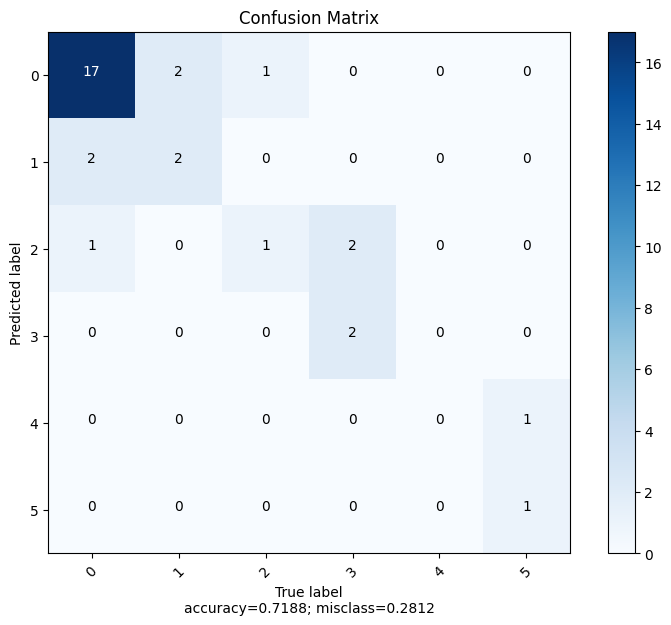

Accuracy for 2010.0000 = 0.7188 


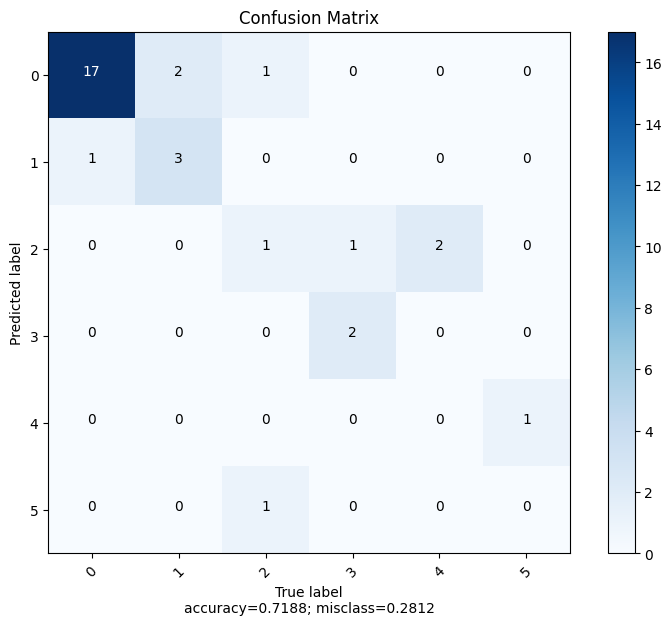

Accuracy for 2011.0000 = 0.7188 


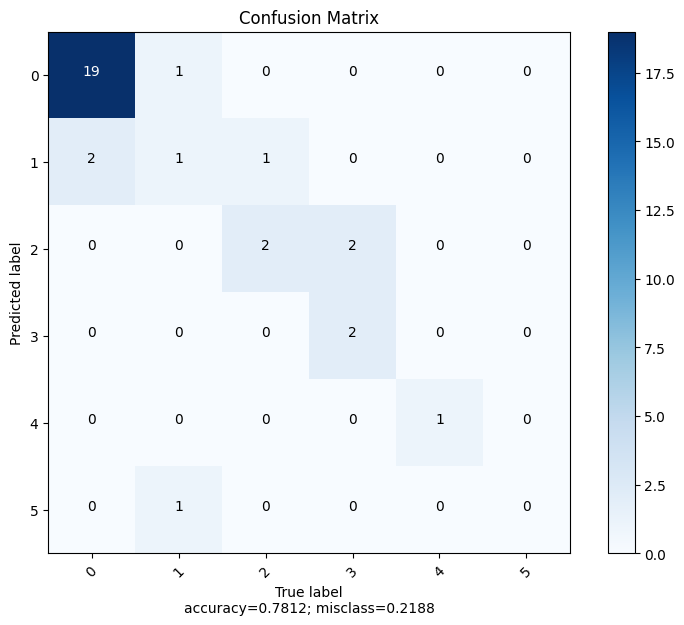

Accuracy for 2012.0000 = 0.7812 


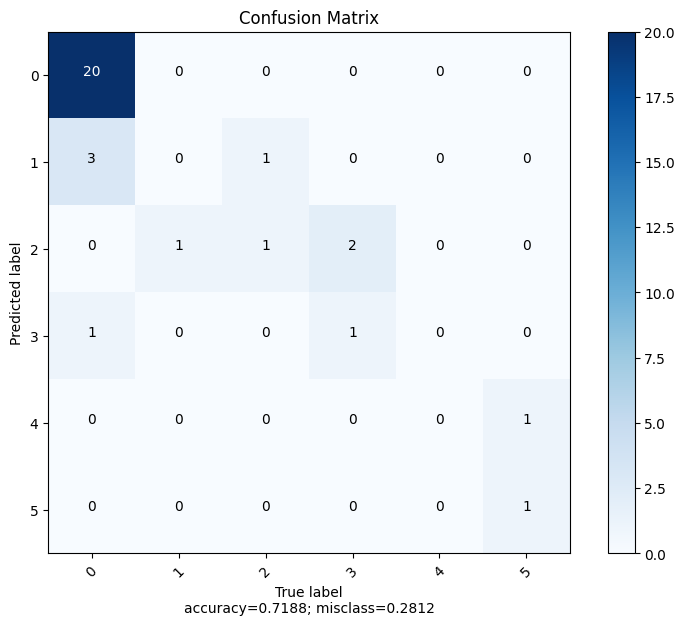

Accuracy for 2013.0000 = 0.7188 


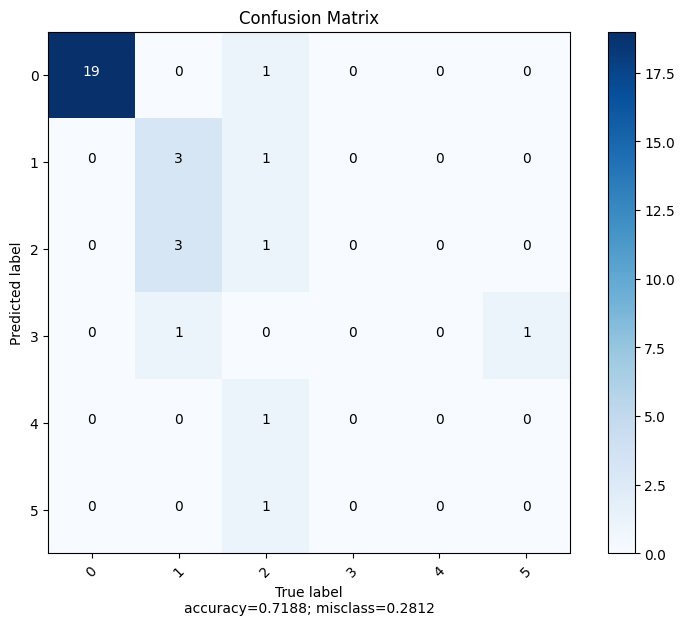

Accuracy for 2014.0000 = 0.7188 


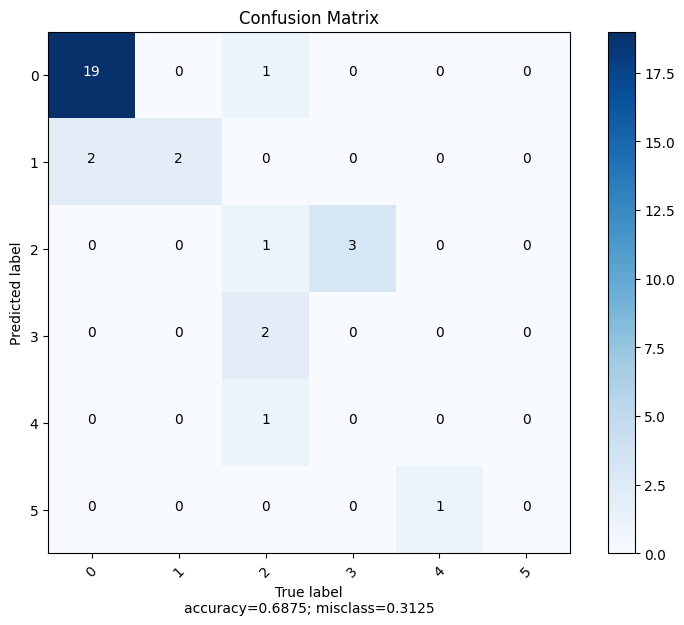

Accuracy for 2015.0000 = 0.6875 


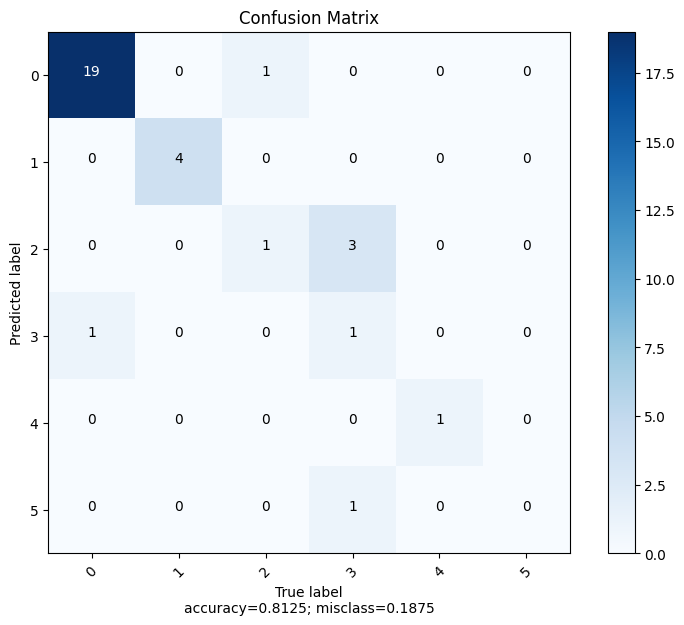

Accuracy for 2016.0000 = 0.8125 


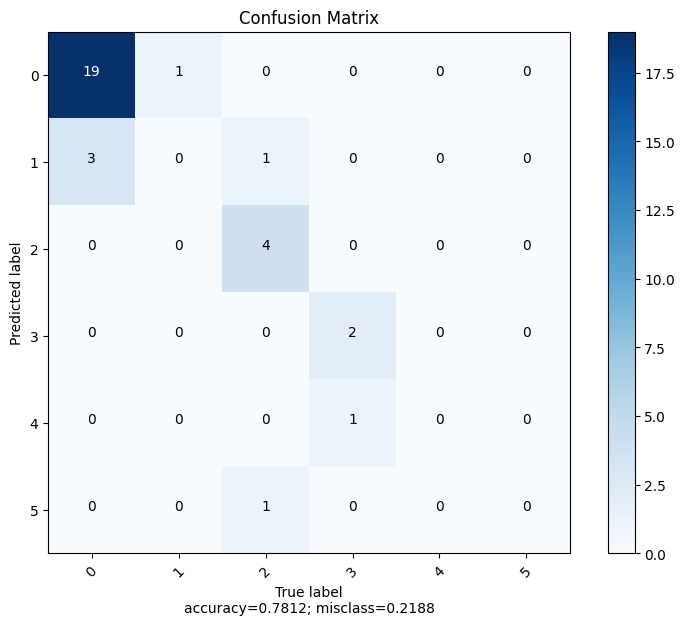

Accuracy for 2017.0000 = 0.7812 


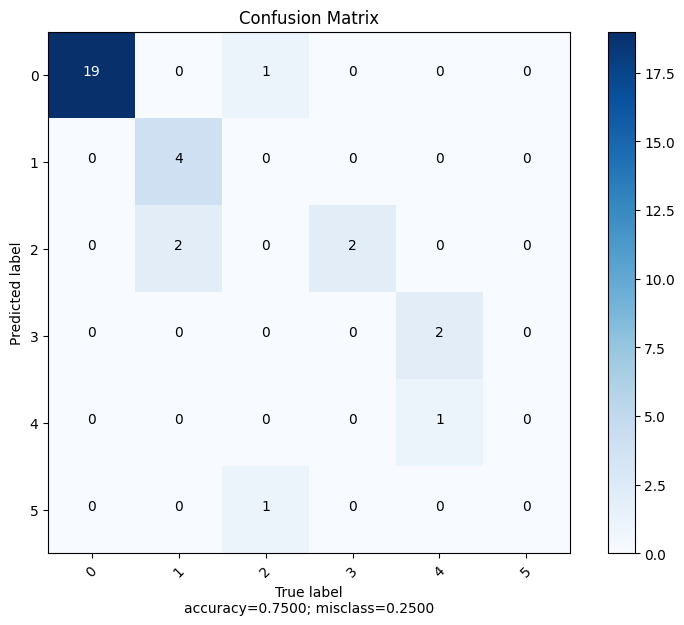

Accuracy for 2018.0000 = 0.7500 


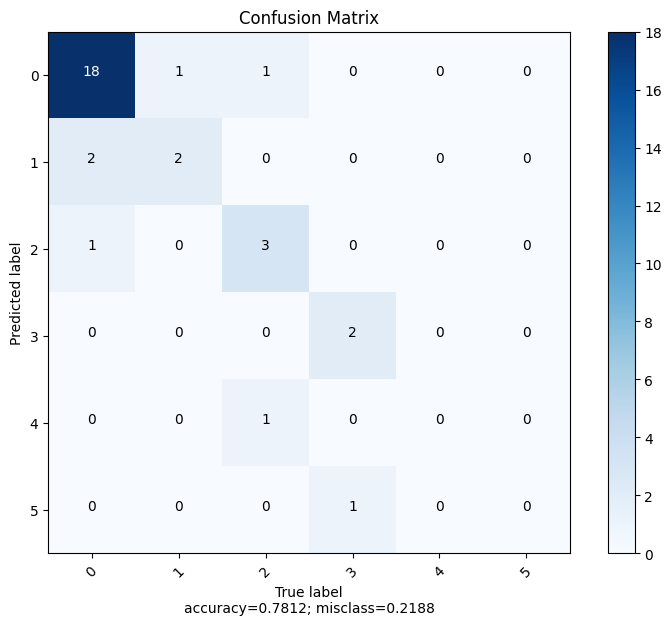

Accuracy for 2019.0000 = 0.7812 


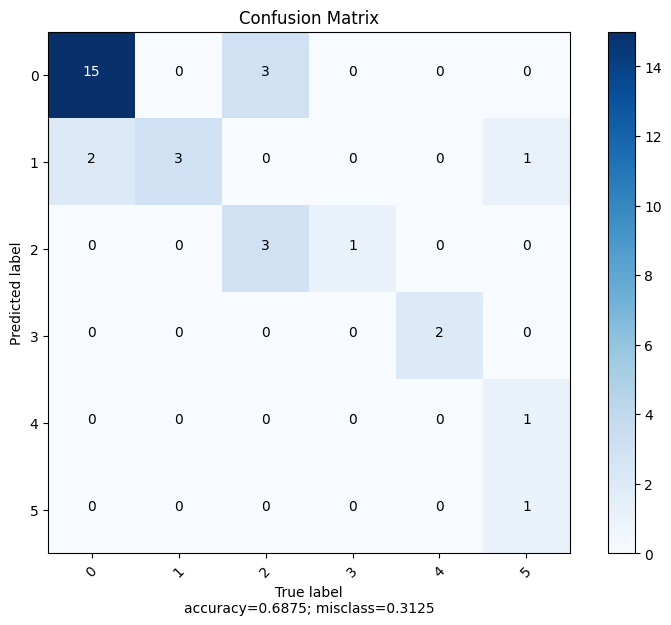

Accuracy for 2020.0000 = 0.6875 


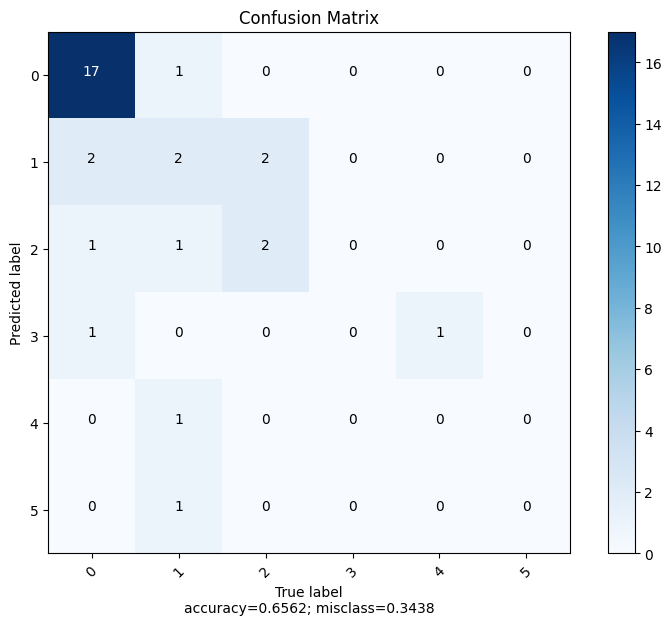

Accuracy for 2021.0000 = 0.6562 


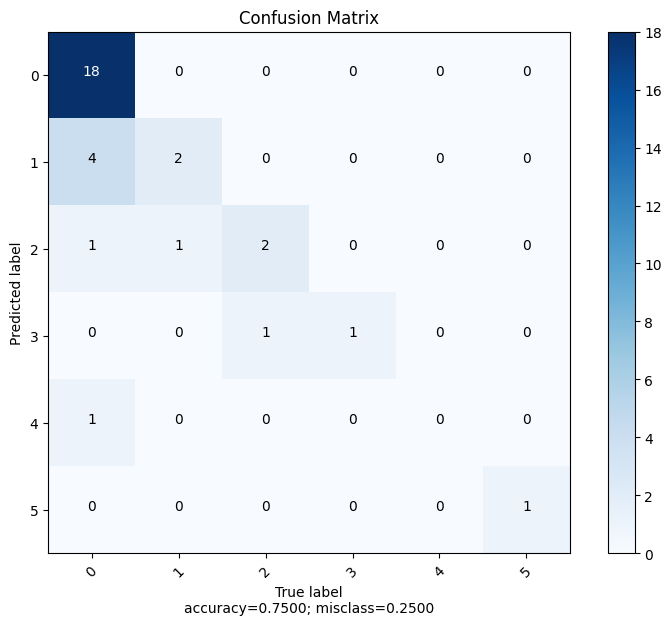

Accuracy for 2022.0000 = 0.7500 


In [ ]:
for x in range(2003, 2023):
  playoff_predictions(x)